# Desafio módulo 4 - Séries temporais

# Resumo:
## A análise dos dados do COVID com foco em série temporal permitirá o uso das ferramentas de análise dos dados de óbitos do estado do Rio de Janeiro
### O objetivo é obter previsões com uma maiores assertividades. Possibilitando melhorar a resposta ao evento com a melhor estratégia de saúde.

## A análise seguiu o roteiro para séries temporais:

- importação das bibliotecas
- configuração das visualizações
- carregamento dos dados
- informações básicas do dataset:
    - Número de linhas e de colunas
    - Tipos de dados
- se a coluna de tempo não for do tipo data, transformá-la e reristrá-la no matplotlib (register_matplotlib_converters())
- fazer a primeira visualização da série com um gráfico de linha (visualização melhorada)
- adicionar colunas ao dataframe com informações complementares para identificar tendências
    - diferença de dados de um dia (mês ou ano) para o outro (diff) para ver o aumento ou diminuição relativa
    - diferença do aumento para ver a aceleração/desaceleração/estagnação da evolução
    - média móvel
- identificar a autocorrelação dos dados
- identificar sazonalidade dos dados (teste de sazonalidade)
- identificar estacionariedade dos dados (teste de estacionariedade)
- fazer modelos de previsão
    - suavização exponencial simples
    - suavização exponencial HoltWinters (com sazonalidade)
    - auto regressivos
    - ARIMA / SARIMA
    - Prophet
- Obter qual o melhor modelo com o uso do erro absoluto e erro quadrado


In [1]:
# Manipulação
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Deixar os gráficos do pyplot com o mesmo tema do seaborn
plt.style.use("seaborn")

# Colocar o tema padão do seaborn
sns.set_theme()

# Aumentar o tamanho dos gráficos e da fonte
plt.rc("figure", figsize=(15,8))
plt.rc("font", size=14)

# deixar o número de casas depois do ponto flutuante fixo em 2 casas
pd.options.display.float_format = "{:.2f}".format

In [2]:
# específicos para séries temporais
from pandas.plotting import register_matplotlib_converters, autocorrelation_plot


from statsmodels.tsa.seasonal import seasonal_decompose # decomposição para identificar sazonalidade
from statsmodels.tsa.stattools import adfuller # estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelação


# modelos
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing # suavização exponencial
from statsmodels.tsa.ar_model import AutoReg # autoregressivo
import statsmodels.tsa.api as smtsa # ARMA
# from statsmodels.tsa.arima_model import ARIMA # ARIMA
from statsmodels.tsa.arima.model import ARIMA # mais atual que o modelo anterior


# métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# !pip install pmdarima     ##### caso necessário
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import nsdiffs
from pmdarima.datasets import load_lynx
from pmdarima import model_selection

In [4]:
# ! pip install plotly    ##### para corrigir warning
# previamente instalado
from fbprophet import Prophet

In [5]:
covid = pd.read_csv('HIST_PAINEL_COVIDBR_07fev2021.csv', sep=';')

display(covid.head(2), covid.tail(2))

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.00,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.00,1,1,0,0,NaN,NaN,NaN


,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
1787710,Centro-Oeste,DF,Brasília,53,530010.00,53001.00,DISTRITO FEDERAL,2021-02-06,5,3015268.00,280599,573,4608,8,NaN,NaN,1.00
1787711,Centro-Oeste,DF,Brasília,53,530010.00,53001.00,DISTRITO FEDERAL,2021-02-07,6,3015268.00,281002,403,4618,10,NaN,NaN,1.00


In [6]:
print(f'O dataframe tem {covid.shape[0]} linhas e {covid.shape[1]} colunas.')

O dataframe tem 1787712 linhas e 17 colunas.


In [7]:
covid.dtypes

regiao                     object
estado                     object
municipio                  object
coduf                       int64
codmun                    float64
codRegiaoSaude            float64
nomeRegiaoSaude            object
data                       object
semanaEpi                   int64
populacaoTCU2019          float64
casosAcumulado              int64
casosNovos                  int64
obitosAcumulado             int64
obitosNovos                 int64
Recuperadosnovos          float64
emAcompanhamentoNovos     float64
interior/metropolitana    float64
dtype: object

In [8]:
covid.data = pd.to_datetime(covid.data)
register_matplotlib_converters()
covid.dtypes

regiao                            object
estado                            object
municipio                         object
coduf                              int64
codmun                           float64
codRegiaoSaude                   float64
nomeRegiaoSaude                   object
data                      datetime64[ns]
semanaEpi                          int64
populacaoTCU2019                 float64
casosAcumulado                     int64
casosNovos                         int64
obitosAcumulado                    int64
obitosNovos                        int64
Recuperadosnovos                 float64
emAcompanhamentoNovos            float64
interior/metropolitana           float64
dtype: object

In [9]:
print(f'O dataframe tem data inicial {covid.data.min().day}/{covid.data.min().month}/{covid.data.min().year} e '
      f'data final {covid.data.max().day}/{covid.data.max().month}/{covid.data.max().year}.')

O dataframe tem data inicial 25/2/2020 e data final 7/2/2021.


---

## Neste estudo foi escolhido o Estado do Rio de Janeiro e

In [10]:
covid_rio = covid[covid['estado'] == 'RJ']
covid_rio = covid_rio[covid_rio['municipio'].isna()]
covid_rio = covid_rio[['estado', 'data', 'semanaEpi', 'casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos']]
covid_rio

,estado,data,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
6633,RJ,2020-02-25,9,0,0,0,0
6634,RJ,2020-02-26,9,0,0,0,0
6635,RJ,2020-02-27,9,0,0,0,0
6636,RJ,2020-02-28,9,0,0,0,0
6637,RJ,2020-02-29,9,0,0,0,0
...,...,...,...,...,...,...,...
1024189,RJ,2021-02-03,5,0,0,0,0
1024190,RJ,2021-02-04,5,0,0,0,0
1024191,RJ,2021-02-05,5,0,0,0,0
1024192,RJ,2021-02-06,5,0,0,0,0


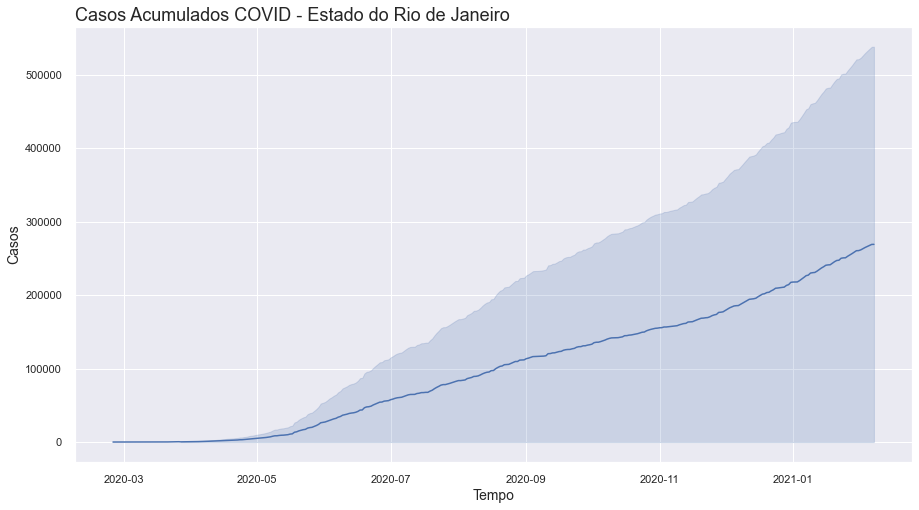

In [11]:
ax = sns.lineplot(x='data', y='casosAcumulado', data=covid_rio)
ax.set_title('Casos Acumulados COVID - Estado do Rio de Janeiro', loc='left', fontsize=18)
ax.set_xlabel('Tempo', fontsize=14)
ax.set_ylabel('Casos', fontsize=14)
ax = ax

## Vendo o gráfico percebemos que há datas repetidas no dataframe

In [12]:
covid_rio[covid_rio['data'] == '2021-02-07']

,estado,data,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
6981,RJ,2021-02-07,6,537986,162,30597,1
1024193,RJ,2021-02-07,6,0,0,0,0


### para comprovar se a obtenção dos dados estava correta e havia duplicados desde o início

In [13]:
covid.query("data == '2021-02-07' & estado == 'RJ'")

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
6981,Sudeste,RJ,NaN,33,NaN,NaN,NaN,2021-02-07,6,17264943.00,537986,162,30597,1,NaN,NaN,NaN
1024193,Sudeste,RJ,NaN,33,330000.00,NaN,NaN,2021-02-07,6,NaN,0,0,0,0,NaN,NaN,NaN
1024511,Sudeste,RJ,Angra dos Reis,33,330010.00,33001.00,BAIA DA ILHA GRANDE,2021-02-07,6,203785.00,10485,0,328,0,NaN,NaN,0.00
1024829,Sudeste,RJ,Aperibé,33,330015.00,33007.00,NOROESTE,2021-02-07,6,11759.00,284,0,10,0,NaN,NaN,0.00
1025147,Sudeste,RJ,Araruama,33,330020.00,33002.00,BAIXADA LITORANEA,2021-02-07,6,132400.00,2954,0,103,0,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052177,Sudeste,RJ,Três Rios,33,330600.00,33003.00,CENTRO-SUL,2021-02-07,6,81804.00,5448,0,99,0,NaN,NaN,0.00
1052495,Sudeste,RJ,Valença,33,330610.00,33004.00,MEDIO PARAIBA,2021-02-07,6,76523.00,1796,0,39,0,NaN,NaN,0.00
1052813,Sudeste,RJ,Varre-Sai,33,330615.00,33007.00,NOROESTE,2021-02-07,6,11000.00,1499,0,5,0,NaN,NaN,0.00
1053131,Sudeste,RJ,Vassouras,33,330620.00,33003.00,CENTRO-SUL,2021-02-07,6,36896.00,1397,0,29,0,NaN,NaN,0.00


### Faremos uma nova manipulação para separar os dados únicos

In [14]:
covid_rio = covid[covid['estado'] == 'RJ']
covid_rio = covid_rio[covid_rio['municipio'].isna()]
covid_rio = covid_rio[['populacaoTCU2019', 'estado', 'data', 'semanaEpi', 'casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos']]
covid_rio

,populacaoTCU2019,estado,data,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
6633,17264943.00,RJ,2020-02-25,9,0,0,0,0
6634,17264943.00,RJ,2020-02-26,9,0,0,0,0
6635,17264943.00,RJ,2020-02-27,9,0,0,0,0
6636,17264943.00,RJ,2020-02-28,9,0,0,0,0
6637,17264943.00,RJ,2020-02-29,9,0,0,0,0
...,...,...,...,...,...,...,...,...
1024189,NaN,RJ,2021-02-03,5,0,0,0,0
1024190,NaN,RJ,2021-02-04,5,0,0,0,0
1024191,NaN,RJ,2021-02-05,5,0,0,0,0
1024192,NaN,RJ,2021-02-06,5,0,0,0,0


In [15]:
covid_rio = covid_rio.dropna(subset=['populacaoTCU2019'])
covid_rio = covid_rio.drop('populacaoTCU2019', axis=1)
covid_rio

,estado,data,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
6633,RJ,2020-02-25,9,0,0,0,0
6634,RJ,2020-02-26,9,0,0,0,0
6635,RJ,2020-02-27,9,0,0,0,0
6636,RJ,2020-02-28,9,0,0,0,0
6637,RJ,2020-02-29,9,0,0,0,0
...,...,...,...,...,...,...,...
6977,RJ,2021-02-03,5,529525,3249,30172,168
6978,RJ,2021-02-04,5,532377,2852,30354,182
6979,RJ,2021-02-05,5,535134,2757,30545,191
6980,RJ,2021-02-06,5,537824,2690,30596,51


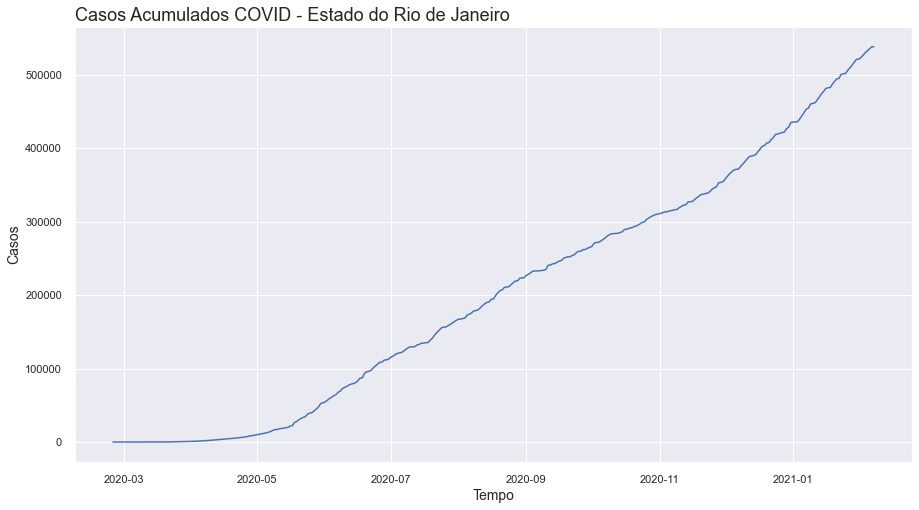

In [16]:
ax = sns.lineplot(x='data', y='casosAcumulado', data=covid_rio)
ax.set_title('Casos Acumulados COVID - Estado do Rio de Janeiro', loc='left', fontsize=18)
ax.set_xlabel('Tempo', fontsize=14)
ax.set_ylabel('Casos', fontsize=14)
ax = ax

### Resolvido o problema dos dados

---

# Analise do Estado do Rio de Janeiro

In [17]:
covid_rio = covid_rio.set_index("data")
covid_rio

,estado,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
data,,,,,,
2020-02-25,RJ,9,0,0,0,0
2020-02-26,RJ,9,0,0,0,0
2020-02-27,RJ,9,0,0,0,0
2020-02-28,RJ,9,0,0,0,0
2020-02-29,RJ,9,0,0,0,0
...,...,...,...,...,...,...
2021-02-03,RJ,5,529525,3249,30172,168
2021-02-04,RJ,5,532377,2852,30354,182
2021-02-05,RJ,5,535134,2757,30545,191


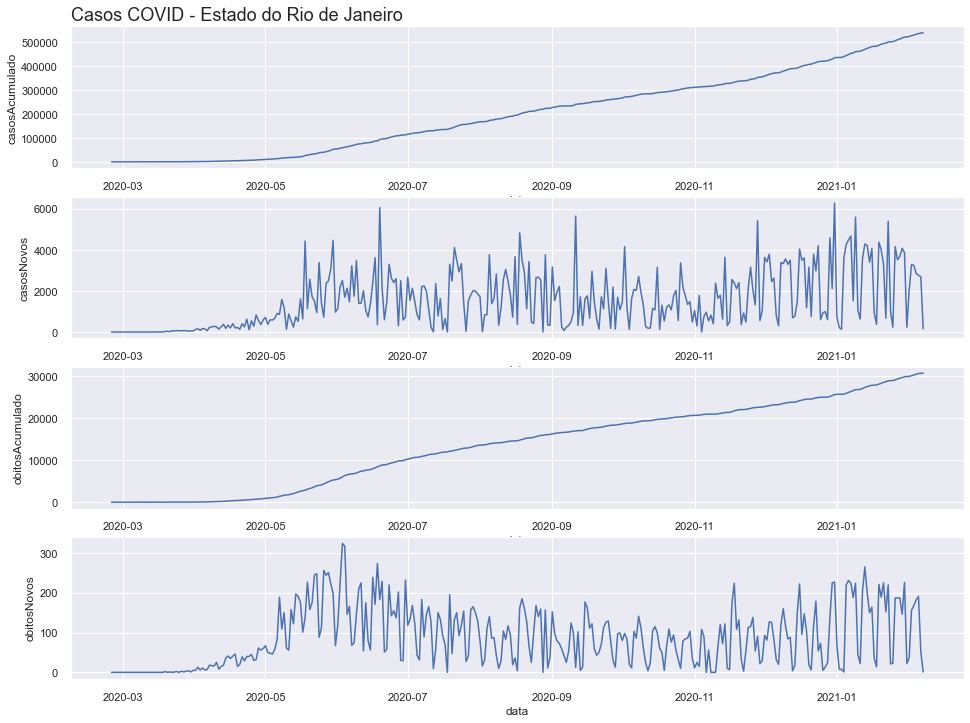

In [18]:
plt.figure(figsize=(16,12))
ax = plt.subplot(4,1,1)
ax.set_title('Casos COVID - Estado do Rio de Janeiro', loc='left', fontsize=18)
ax = sns.lineplot(x='data', y='casosAcumulado', data=covid_rio)
plt.subplot(4,1,2)
ax = sns.lineplot(x='data', y='casosNovos', data=covid_rio)
plt.subplot(4,1,3)
ax = sns.lineplot(x='data', y='obitosAcumulado', data=covid_rio)
plt.subplot(4,1,4)
ax = sns.lineplot(x='data', y='obitosNovos', data=covid_rio)
ax = ax

### Avaliando os gráficos podemos perceber que a informação de dados acumulador tem a importância de ver como se comportou a doença, mas dificulta análise do "dia-a-dia"
### O gráfico de casos diários e óbitos diários são bastante representativos da dinâmica, embora essa doença tenha uma característica de ser identificada de 7 a 14 dias depois do contágio, inevitávelmente o número de hoje é uma imagem das atitudes do passado

---

### Depois de uma visão geral, inicialmente focaremos nos óbitos diários

In [19]:
covid_rio

,estado,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
data,,,,,,
2020-02-25,RJ,9,0,0,0,0
2020-02-26,RJ,9,0,0,0,0
2020-02-27,RJ,9,0,0,0,0
2020-02-28,RJ,9,0,0,0,0
2020-02-29,RJ,9,0,0,0,0
...,...,...,...,...,...,...
2021-02-03,RJ,5,529525,3249,30172,168
2021-02-04,RJ,5,532377,2852,30354,182
2021-02-05,RJ,5,535134,2757,30545,191


## Fazer um teste de integridade para avaliar se os dados de óbitos novos são a diferença dos dados acumulados

In [20]:
teste = covid_rio.obitosAcumulado.diff() - covid_rio.obitosNovos
teste

data
2020-02-25    NaN
2020-02-26   0.00
2020-02-27   0.00
2020-02-28   0.00
2020-02-29   0.00
             ... 
2021-02-03   0.00
2021-02-04   0.00
2021-02-05   0.00
2021-02-06   0.00
2021-02-07   0.00
Length: 349, dtype: float64

In [21]:
teste.unique()

array([nan,  0.])

### Comprovado

---

### Análise de médias móveis para identificar tendência

### Como dito anteriormente, a doença representa a consequência das atitudes tomadas de 7 a 14 dias anteriores

In [22]:
covid_rio['mediaMovel14'] = covid_rio['obitosNovos'].rolling(14).mean()
covid_rio['mediaMovel7'] = covid_rio['obitosNovos'].rolling(7).mean()
covid_rio

,estado,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,mediaMovel14,mediaMovel7
data,,,,,,,,
2020-02-25,RJ,9,0,0,0,0,NaN,NaN
2020-02-26,RJ,9,0,0,0,0,NaN,NaN
2020-02-27,RJ,9,0,0,0,0,NaN,NaN
2020-02-28,RJ,9,0,0,0,0,NaN,NaN
2020-02-29,RJ,9,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-02-03,RJ,5,529525,3249,30172,168,139.79,134.57
2021-02-04,RJ,5,532377,2852,30354,182,136.71,133.86
2021-02-05,RJ,5,535134,2757,30545,191,139.50,140.29


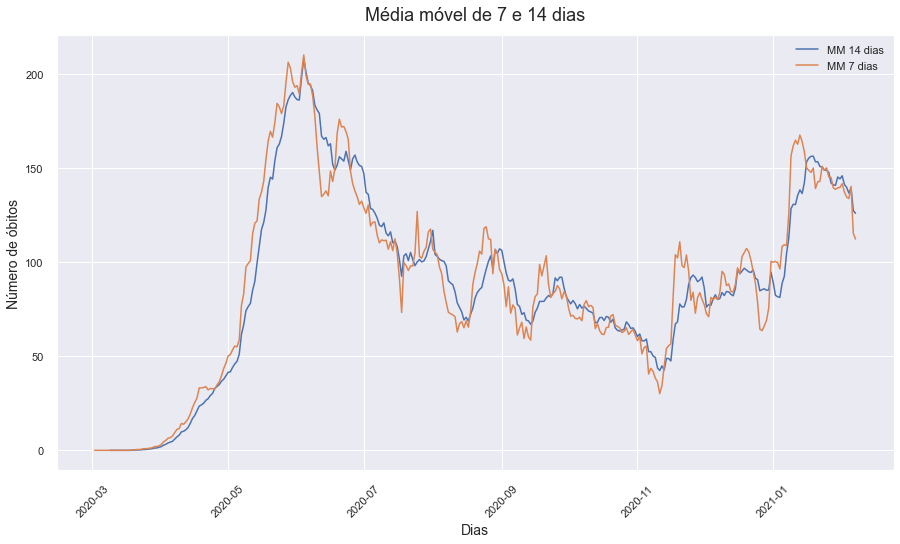

In [23]:
sns.lineplot(x='data', y='mediaMovel14', data=covid_rio)
sns.lineplot(x='data', y='mediaMovel7', data=covid_rio)
plt.title('Média móvel de 7 e 14 dias', pad=15, fontsize=18)
plt.xlabel('Dias', fontsize=14)
plt.ylabel('Número de óbitos', fontsize=14)
plt.xticks(rotation= 45)
plt.legend(['MM 14 dias', 'MM 7 dias'])
plt.show()

 ## Diferença de tendência da média móvel de 14 dias e de 7 dias apresenta pouca diferença

---

## Feito um teste para confirmar se a coluna de obitos novos é a diferença dos casos acumulados do dia com o dia anterior

### Criação de uma coluna para identificar de está havendo aumento relativo de óbitos por dia

In [24]:
covid_rio['obitosAumento'] = covid_rio.obitosNovos.diff()
covid_rio

,estado,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,mediaMovel14,mediaMovel7,obitosAumento
data,,,,,,,,,
2020-02-25,RJ,9,0,0,0,0,NaN,NaN,NaN
2020-02-26,RJ,9,0,0,0,0,NaN,NaN,0.00
2020-02-27,RJ,9,0,0,0,0,NaN,NaN,0.00
2020-02-28,RJ,9,0,0,0,0,NaN,NaN,0.00
2020-02-29,RJ,9,0,0,0,0,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...
2021-02-03,RJ,5,529525,3249,30172,168,139.79,134.57,12.00
2021-02-04,RJ,5,532377,2852,30354,182,136.71,133.86,14.00
2021-02-05,RJ,5,535134,2757,30545,191,139.50,140.29,9.00


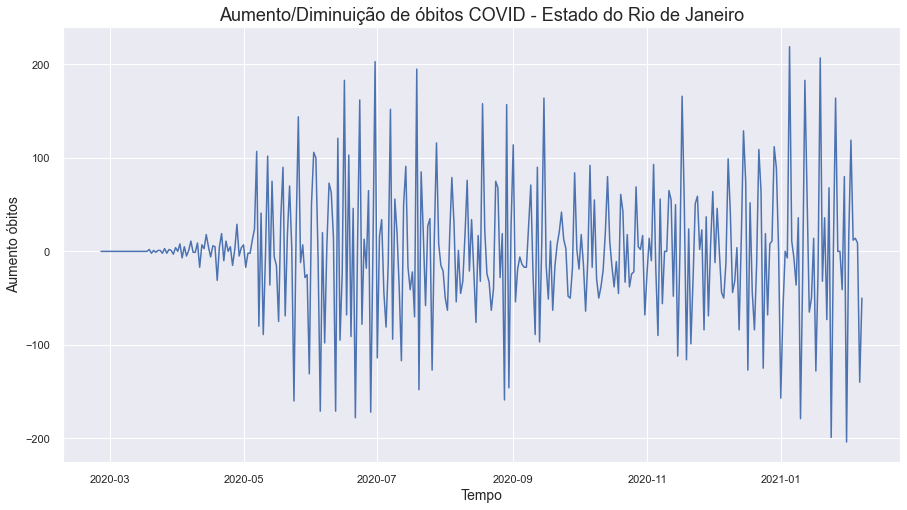

In [25]:
ax = sns.lineplot(x='data', y='obitosAumento', data=covid_rio)
ax.set_title('Aumento/Diminuição de óbitos COVID - Estado do Rio de Janeiro', fontsize=18)
ax.set_xlabel('Tempo', fontsize=14)
ax.set_ylabel('Aumento óbitos', fontsize=14)
ax = ax

In [26]:
covid_rio['obitosAumento'].mean()

0.0028735632183908046

### Analisando o aumento dos casos por dia percebemos que há grande flutuação em torno do zero, demonstrando que não há um aumento constante dos óbitos nem diminuição.
### Interessante que a média da flutuação entre aumento e diminuição dos óbitos é um número próximo a zero, o que não demonstra que está estabilizado está completamente sem controle

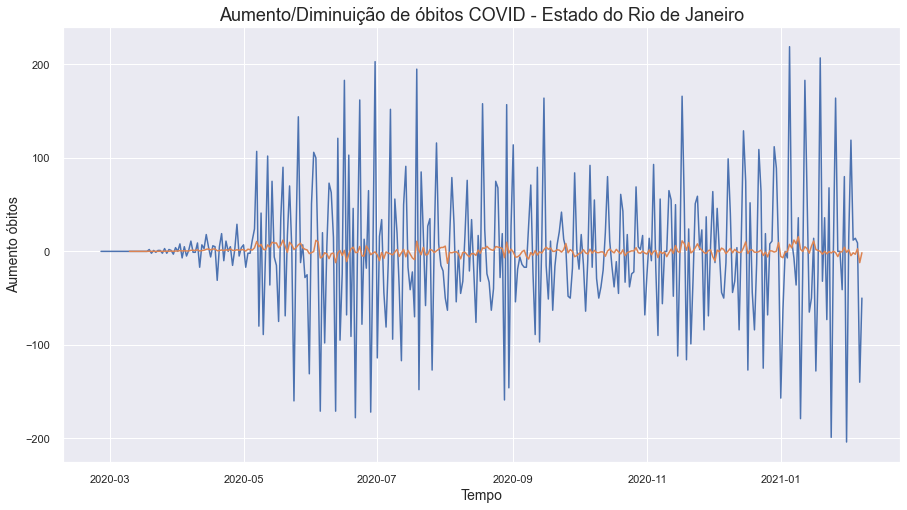

In [27]:
covid_rio['mediaMovelObitosAumento'] = covid_rio['obitosAumento'].rolling(14).mean()

sns.lineplot(x='data', y='obitosAumento', data=covid_rio)
sns.lineplot(x='data', y='mediaMovelObitosAumento', data=covid_rio)

plt.title('Aumento/Diminuição de óbitos COVID - Estado do Rio de Janeiro', fontsize=18)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Aumento óbitos', fontsize=14)
plt.show();

## A curva aparentemente é muito próxima a uma curva estacionária

### Uma segunda característica de uma curva estacionária é a distribuição ser normal

<AxesSubplot:>

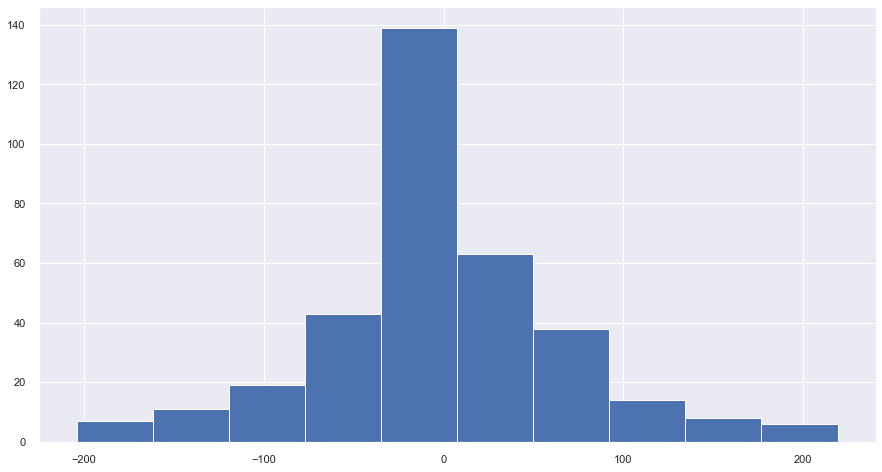

In [28]:
covid_rio.obitosAumento[1:].hist()

## Faremos um teste de estacionariedade

In [29]:
adfuller(covid_rio.obitosAumento.values[1:])

(-7.115538291780175,
 3.8396022771052617e-10,
 12,
 335,
 {'1%': -3.4500219858626227,
  '5%': -2.870206553997666,
  '10%': -2.571387268879483},
 3454.2398967366225)

### De acordo com a documentação o segundo valor é o p-valor do teste

In [30]:
adfuller(covid_rio.obitosAumento.values[1:])[1]

3.8396022771052617e-10

## Comprovamos que a curva é estacionária

---

## Agora vamos analisar a auto correlação total e parcial da curva

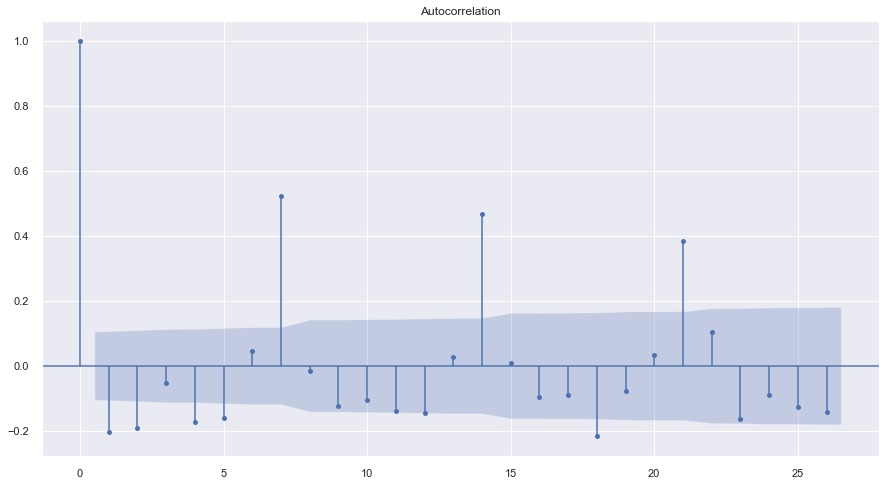

In [31]:
plot_acf(covid_rio['obitosAumento'][1:]);
## coloquei a partir do segundo número porque a função nao aceita NaN

### Como esperado, Identificamos uma correlação alta nos dias 7, 14 e 21 um padrão de repetição semanal conforme o ciclo do covid

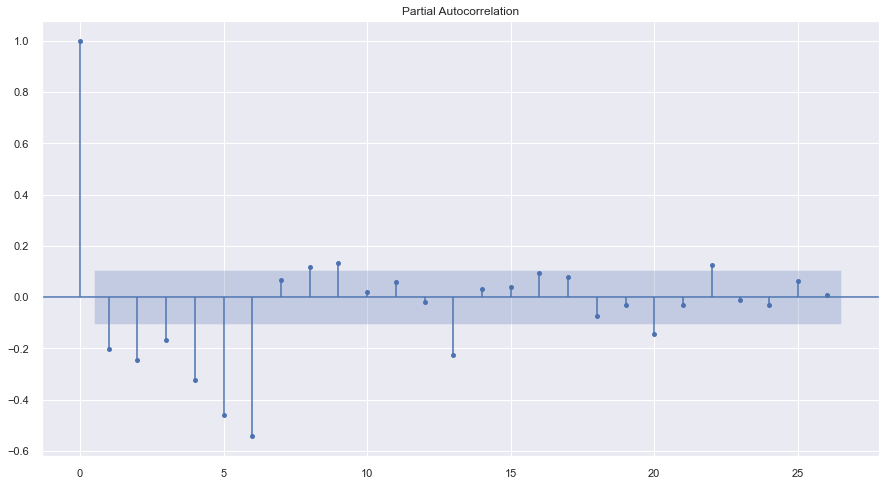

In [32]:
plot_pacf(covid_rio['obitosAumento'][1:]);

### Na correlação parcial os 6 primeiros lags tem uma correlação inversa que é importante

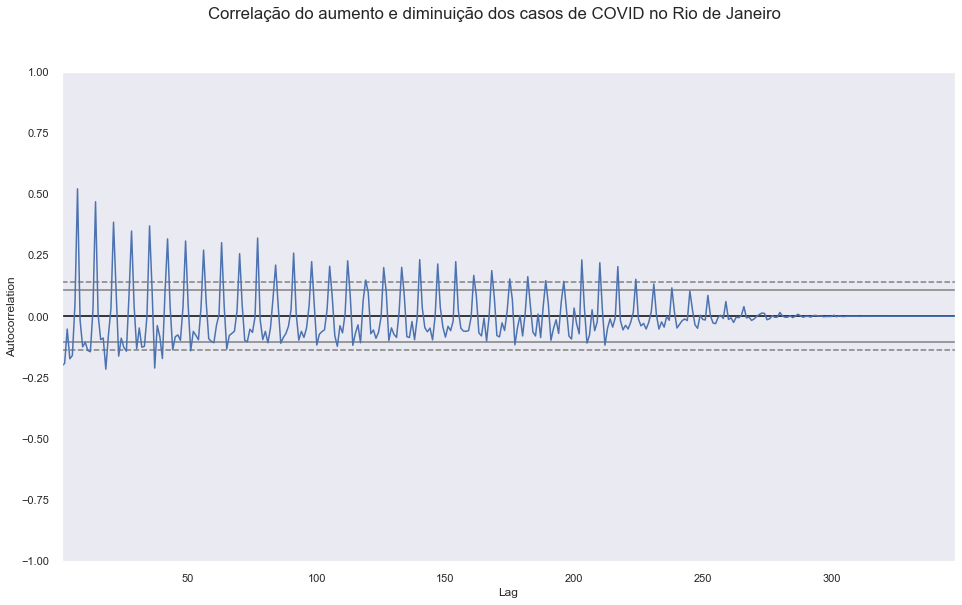

In [33]:
plt.figure(figsize=(16,9))
plt.suptitle('Correlação do aumento e diminuição dos casos de COVID no Rio de Janeiro')
autocorrelation_plot(covid_rio['obitosAumento'][1:])
plt.show()

---

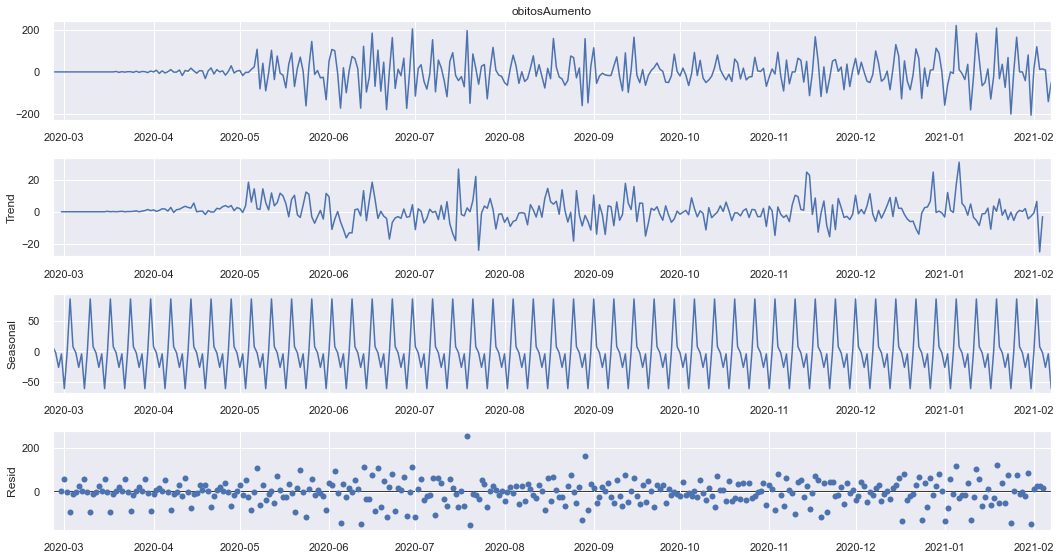

In [34]:
seasonal_decompose(covid_rio['obitosAumento'][1:]).plot();

---

## A partir daqui faremos um teste de previsão para o aumento ou diminuição do número de óbitos

### Primeiramente faremos a separação dos dados de treino e dados de teste

In [35]:
covid_rio[covid_rio.index.year == 2020]

,estado,semanaEpi,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,mediaMovel14,mediaMovel7,obitosAumento,mediaMovelObitosAumento
data,,,,,,,,,,
2020-02-25,RJ,9,0,0,0,0,NaN,NaN,NaN,NaN
2020-02-26,RJ,9,0,0,0,0,NaN,NaN,0.00,NaN
2020-02-27,RJ,9,0,0,0,0,NaN,NaN,0.00,NaN
2020-02-28,RJ,9,0,0,0,0,NaN,NaN,0.00,NaN
2020-02-29,RJ,9,0,0,0,0,NaN,NaN,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,RJ,53,421069,994,24918,13,85.43,63.57,8.00,0.64
2020-12-28,RJ,53,421674,605,24942,24,85.86,66.14,11.00,0.43
2020-12-29,RJ,53,426259,4585,25078,136,85.07,69.14,112.00,-0.79


In [36]:
obitos_rio = covid_rio['obitosAumento'][1:]
dados_treino = obitos_rio[1:311]
dados_teste = obitos_rio[311:]

### Como dados de treino usaremos os dados de 2020 e os dados de teste usaremos os dados de 2021

In [37]:
len(dados_treino)

310

In [38]:
len(dados_teste)

37

### 1. Suavização simples

In [39]:
modelo_suav_simples = SimpleExpSmoothing(dados_treino).fit()

C:\Users\dudu_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\dudu_\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [40]:
modelo_suav_previsto_simples = modelo_suav_simples.forecast(37)

<AxesSubplot:xlabel='data'>

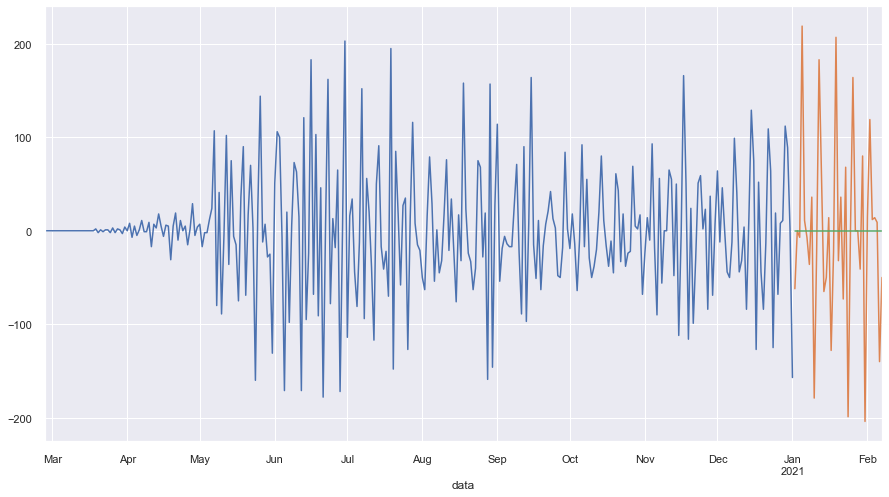

In [41]:
dados_treino.plot()
dados_teste.plot()
modelo_suav_previsto_simples.plot()

## Com a previsão o modelo diz que o aumento seria igual a zero, ou seja, estabilidade no número

---

### 2. Suavização exponencial

In [42]:
modelo_suav_exp = ExponentialSmoothing(dados_treino.values, trend='additive', seasonal='additive', seasonal_periods=49).fit()
modelo_suav_exp_previsto = modelo_suav_exp.predict(start=311, end=347)

C:\Users\dudu_\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


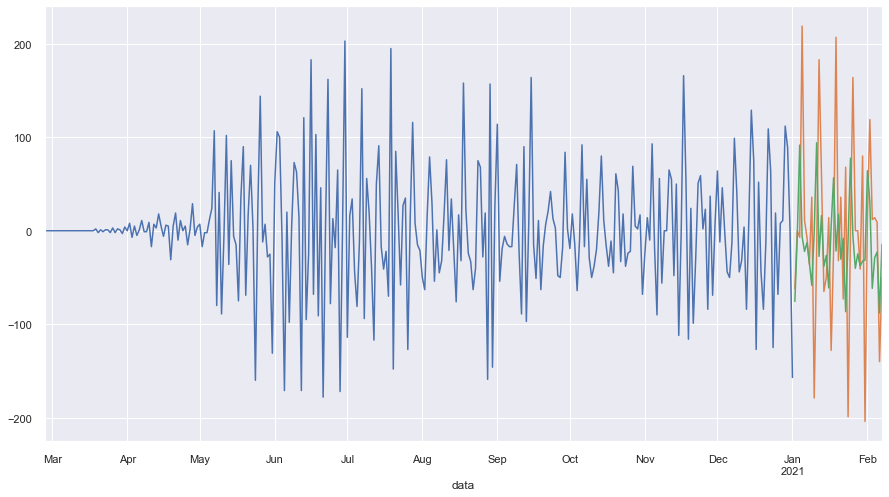

In [43]:
dados_treino.plot()
dados_teste.plot()
plt.plot(dados_teste.index, modelo_suav_exp_previsto)

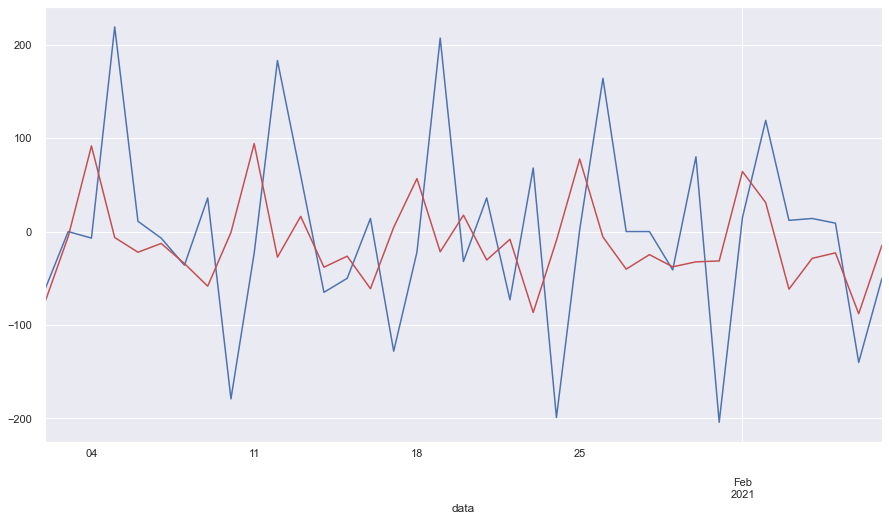

In [44]:
dados_teste.plot()
plt.plot(dados_teste.index, modelo_suav_exp_previsto, 'r')

### Esse foi um bom modelo de previsão, mas errou na amplitude 

## 3. Autoregressivo

In [45]:
modelo_autoreg = AutoReg(dados_treino.values, lags=np.linspace(1,60,60), trend='c', seasonal=True, period=49).fit()
modelo_autoreg_previsto = modelo_autoreg.predict(start=311, end=347)

C:\Users\dudu_\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


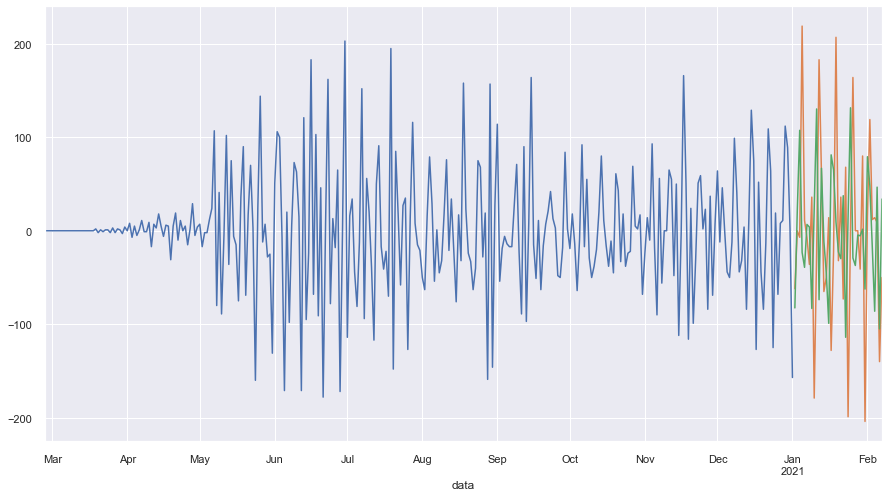

In [46]:
dados_treino.plot()
dados_teste.plot()
plt.plot(dados_teste.index, modelo_autoreg_previsto)

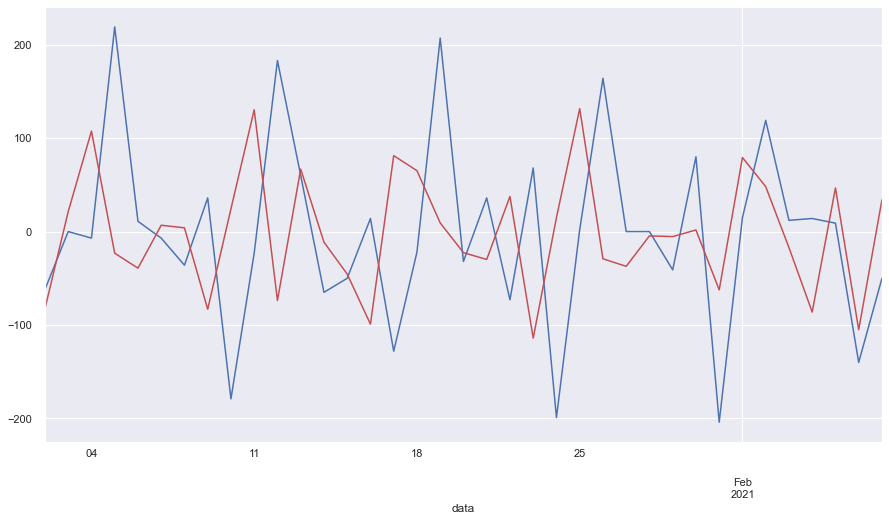

In [47]:
dados_teste.plot()
plt.plot(dados_teste.index, modelo_autoreg_previsto, 'r')

## 4. ARIMA

In [48]:
modelo_arima = ARIMA(dados_treino.values, order=(14,0,7))
modelo_arima_treinado = modelo_arima.fit()
previsao_arima = modelo_arima_treinado.forecast(37)

C:\Users\dudu_\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dudu_\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dudu_\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


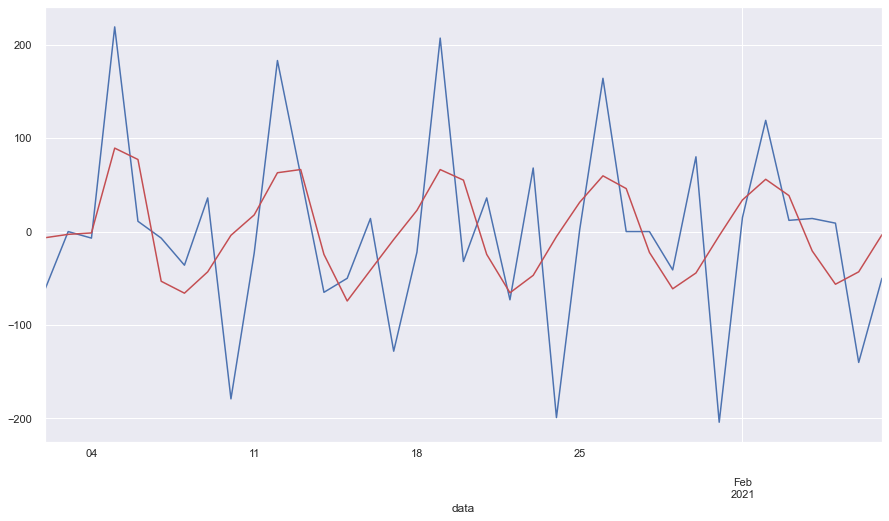

In [49]:
# dados_treino.plot()
dados_teste.plot()
plt.plot(dados_teste.index, previsao_arima, 'r')

## 5. Auto ARIMA

In [50]:
modelo_autoarima = auto_arima(dados_treino.values, error_action='ignore', trace=True)
previsao_autoarima = modelo_autoarima.predict(37)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3351.700, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3457.345, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3441.518, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3376.431, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3455.349, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3350.975, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3349.360, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=3350.676, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3355.731, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3338.793, Time=0.61 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3246.480, Time=1.28 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3244.288, Time=1.33 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3234.250, Time=1.14 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : 

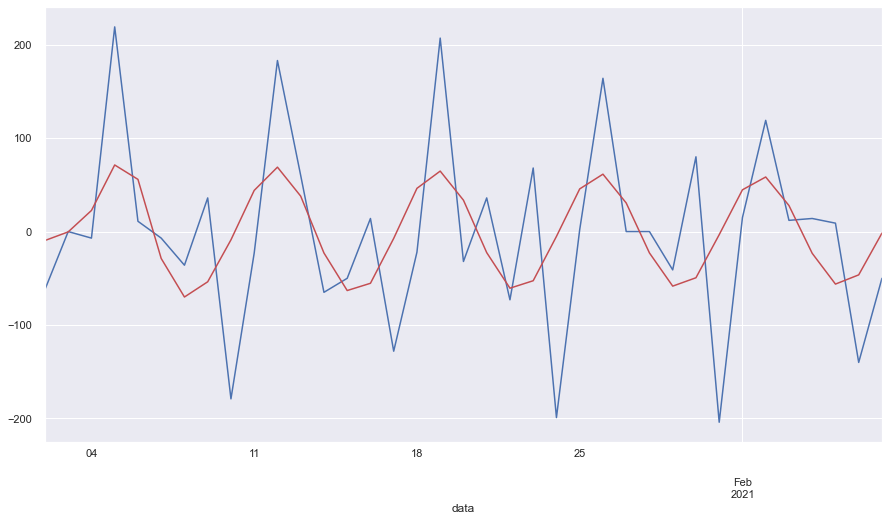

In [51]:
dados_teste.plot()
plt.plot(dados_teste.index, previsao_autoarima, 'r')

In [52]:
modelo_teste_modificado = auto_arima(dados_treino.values, error_action='ignore', 
                              trace=True, max_q=24 , max_p=21 , max_d=21, max_P=21, max_D=21, max_Q=21, max_order=21, m=21)
previsao_autoarima_teste = modelo_teste_modificado.predict(37)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[21] intercept   : AIC=3261.682, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[21] intercept   : AIC=3457.345, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[21] intercept   : AIC=3378.919, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[21] intercept   : AIC=3323.148, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[21]             : AIC=3455.349, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[21] intercept   : AIC=3310.970, Time=0.77 sec
 ARIMA(2,0,2)(1,0,0)[21] intercept   : AIC=3290.541, Time=0.81 sec
 ARIMA(2,0,2)(2,0,1)[21] intercept   : AIC=inf, Time=4.66 sec
 ARIMA(2,0,2)(1,0,2)[21] intercept   : AIC=3262.022, Time=4.34 sec
 ARIMA(2,0,2)(0,0,0)[21] intercept   : AIC=3351.700, Time=0.23 sec
 ARIMA(2,0,2)(0,0,2)[21] intercept   : AIC=3302.966, Time=3.75 sec
 ARIMA(2,0,2)(2,0,0)[21] intercept   : AIC=3279.297, Time=2.75 sec
 ARIMA(2,0,2)(2,0,2)[21] intercept   : AIC=3263.349, Time=5.53 sec
 ARIMA(1,0,2)(1,0,1)[21] intercept   : AIC=3259.765, Time=0.88 sec
 ARIMA(1,0,2)(0,0,1)[21]

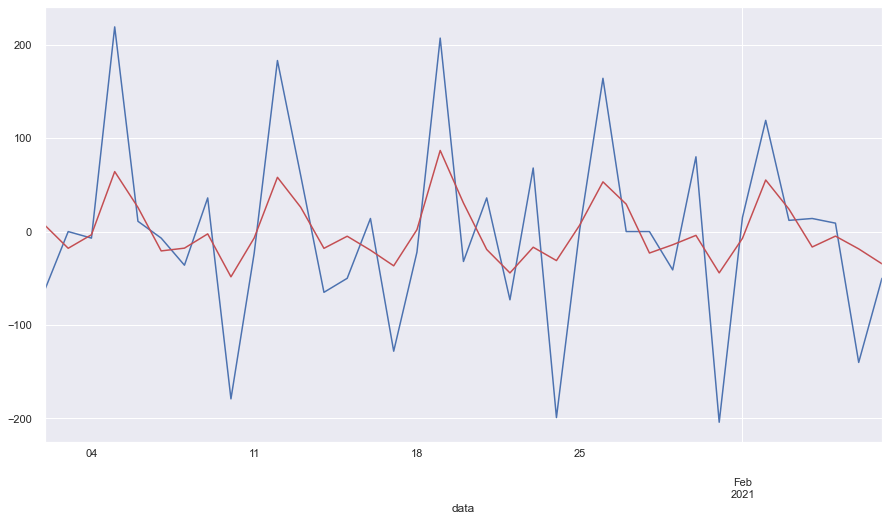

In [53]:
dados_teste.plot()
plt.plot(dados_teste.index, previsao_autoarima_teste, 'r')

## 6. Prophet

In [54]:
modelo_profeta = Prophet(daily_seasonality=True, yearly_seasonality=True)
mapa = {'data':'ds', 'obitosAumento':'y'}
dados_treino_profeta = dados_treino.reset_index()
dados_treino_profeta = dados_treino_profeta[['data', 'obitosAumento']].rename(mapa, axis=1)
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_profeta)


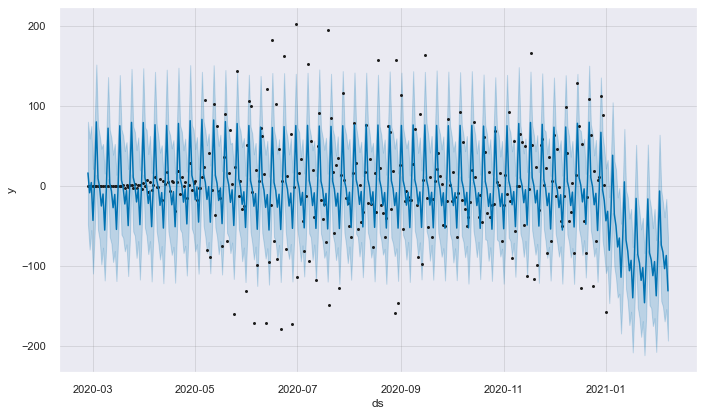

In [55]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=37, freq='D')
resultado_profeta = modelo_profeta_treinado.predict(futuro)
modelo_profeta_treinado.plot(resultado_profeta);

---

## Obtenção do melhor modelo

In [56]:
resultado_suav_simp = mean_squared_error(dados_teste, modelo_suav_previsto_simples)
resultado_suav_exp = mean_squared_error(dados_teste, modelo_suav_exp_previsto)
resultado_autoreg = mean_squared_error(dados_teste, modelo_autoreg_previsto)
resultado_arima = mean_squared_error(dados_teste, previsao_arima)
resultado_autoarima = mean_squared_error(dados_teste, previsao_autoarima)

In [57]:
print(f"Suavização simples: {resultado_suav_simp}")
print(f"Suavização exponencial: {resultado_suav_exp}")
print(f"Autoregressivo: {resultado_autoreg}")
print(f"ARIMA: {resultado_arima}")
print(f"AUTO ARIMA: {resultado_arima}")

Suavização simples: 9630.184608374175
Suavização exponencial: 11291.280482715896
Autoregressivo: 14494.479729796734
ARIMA: 7452.848634079582
AUTO ARIMA: 7452.848634079582


# O melhor modelo de previsão de acordo com o método da média do erro quadrado é o ARIMA/AUTOARIMA